 <p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>


# Linear Regression to predict stock prices

</br>

In this chapter, we will explain how the linear regression works theorically. Then, we will apply this algorithm to predict stock price and create a trading strategy

### Summary
* How a Liner Regression algorithm work theorically
* Predict stock price using a Linear Regression
* Create trading strategy 

</br>

💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
! pip install yfinance
! pip install ta

     |████████████████████████████████| 6.3 MB 7.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=2f24aaf9f2b0c388405c4e7c960c0950f637b12600f0d0333f7814fbe4b5a881
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import ta

In [ ]:
import matplotlib as mpl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# How a Liner Regression algorithm works theorically
Look the video and the attached PDF.

# Predict stock prices using a Linear Regression


### Import the data from Yahoo (esiest choice)

**IMPORTANT**: You can import the data from Yahoo or from MT5. But you need to have a Windows device to use MT5. To avoid this problem, you can see the video introduction video of the chapter MetaTrader 5 Live Trading! 

In [ ]:
# Import the data
df = yf.download("GOOG")

# Take adjusted close
df = df[["Adj Close"]]

# Rename the column
df.columns = ["close"]
df

[*********************100%***********************]  1 of 1 completed


,close
Date,
2004-08-19,49.982655
2004-08-20,53.952770
2004-08-23,54.495735
2004-08-24,52.239197
2004-08-25,52.802086
...,...
2021-11-10,2932.520020
2021-11-11,2934.959961
2021-11-12,2992.909912


### Features Engineering



In [ ]:
def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()

In [ ]:
dfc = feature_engineering(df)
dfc

,close,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,
2004-11-12,90.660187,-0.005573,91.001902,67.843456,0.045158,0.045223,60.962971
2004-11-15,92.089828,0.015769,91.319711,68.521415,0.045046,0.045295,62.484309
2004-11-16,85.947845,-0.066696,91.235693,69.157033,0.044225,0.045283,52.938988
2004-11-17,85.927917,-0.000232,90.928179,69.681234,0.048354,0.047390,52.910746
2004-11-18,83.457184,-0.028754,90.480856,70.242713,0.048425,0.047302,49.392430
...,...,...,...,...,...,...,...
2021-11-10,2932.520020,-0.017571,2901.391341,2838.389164,0.019565,0.016162,55.682186
2021-11-11,2934.959961,0.000832,2907.006006,2841.497664,0.014452,0.016367,55.931997
2021-11-12,2992.909912,0.019745,2912.295996,2844.890332,0.014430,0.016207,61.484916


### Create different sets of data

In [ ]:
dfc.columns

Index(['close', 'returns', 'SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi'], dtype='object')

In [ ]:
# Percentage train set
split = int(0.80*len(dfc))

# Train set creation
X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
y_train = dfc[["returns"]].iloc[:split]


# Test set creation
X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
y_test = dfc[["returns"]].iloc[split:]

### Linear Regression training

In [ ]:
# Import the class
from sklearn.linear_model import LinearRegression

# Initialize the class
reg = LinearRegression()

# Fit the model
reg.fit(X_train, y_train)

LinearRegression()

### Linear Regression predictions

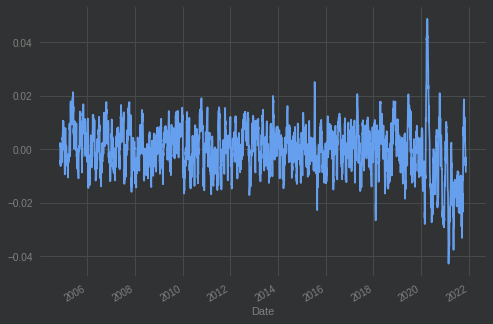

In [ ]:
# Create predictions for the whole dataset
X = np.concatenate((X_train, X_test), axis=0)

dfc["prediction"] = reg.predict(X)

# We verify that the algorithm doesn't predict only way (positive or negative)
dfc["prediction"].plot()

### Compute the profit 

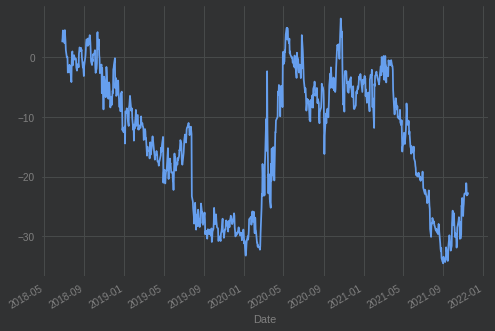

In [ ]:
# Compute the position
dfc["position"] = np.sign(dfc["prediction"])

# Compute the returns
dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


(dfc["strategy"].iloc[split:].cumsum()*100).plot()

In [ ]:
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Import the data
  df = yf.download(symbol)

  # Take adjusted close
  df = df[["Adj Close"]]

  # Rename the column
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


  (dfc["strategy"].iloc[split:].cumsum()*100).plot()

[*********************100%***********************]  1 of 1 completed


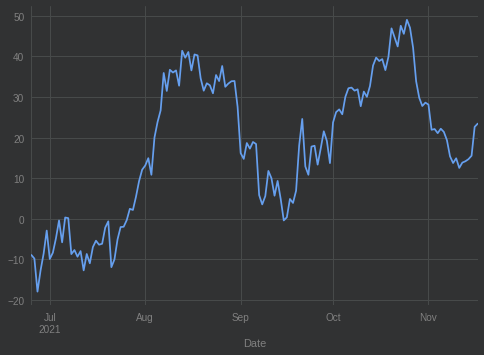

In [ ]:
lin_reg_trading("ETH-EUR")